Reconstructing HHL algorithm for multiple linear regression (MLR) based on the paper "Quantum circuit design methodology for multiple linear regression" from https://arxiv.org/abs/1811.01726

In [2]:
%matplotlib inline

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import noise
from qiskit.circuit.library import QFT

import numpy as np

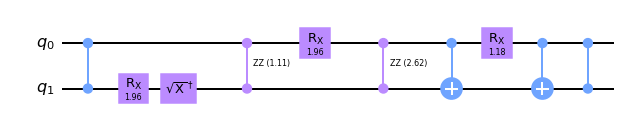

In [17]:
def f(n):
    ang1 = [-9.014e-9, -0.785, 1.963, 0.196]
    ang2 = [-0.75, 1.017, 1.115, 0.379]
    ang3 = [1.571, 3.927, 1.963, 0.981]
    ang4 = [0.75, 2.517, 2.615, 0.589]
    ang5 = [-1.571, 2.356, 1.178, 1.178]
    
    qcs = []
    
    for i in range(n):
        qc = QuantumCircuit(2)

        qc.cz(0, 1)
        qc.rx(ang1[i], 1)
        qc.sxdg(1)
        qc.rzz(ang2[i], 1, 0)
        qc.rx(ang3[i], 0)
        qc.rzz(ang4[i], 0, 1)
        qc.cx(0, 1)
        qc.rx(ang5[i], 0)
        qc.cx(0, 1)
        qc.cz(0, 1)
    
        qcs.append(qc)
    return qcs

qc_ = f(4)

qg1 = qc_[0].to_gate().control(1)
qg1.name = "f1"
qg2 = qc_[1].to_gate().control(1)
qg2.name = "f2"
qg4 = qc_[2].to_gate().control(1)
qg4.name = "f4"
qg8 = qc_[3].to_gate().control(1)
qg8.name = "f8"

qc_[2].draw('mpl')

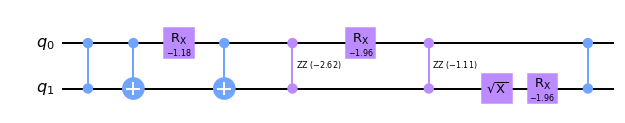

In [18]:
qc_[2].inverse().draw('mpl')

In [19]:
def nQFT(q, n):
    qc = QuantumCircuit(q)
    #for i in range(len(q)):
        #qc.h(q[i])
    
    for k in range(n):
        j = n-k
        qc.h(q[j-1])
        
        for i in reversed(range(j-1)):
            qc.cp(np.pi/2**(j-1), q[i], q[j-1])
            
    for i in range(n//2):
        qc.swap(q[i], q[n-i-1])
    qft1 = qc.to_gate()
    qft1.name = "QFT"
    return qft1

def nIQFT(q, n):
    qc = QuantumCircuit(q)
    
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    
    iqft1 = qc.to_gate()
    iqft1.name = "IQFT"
    return iqft1

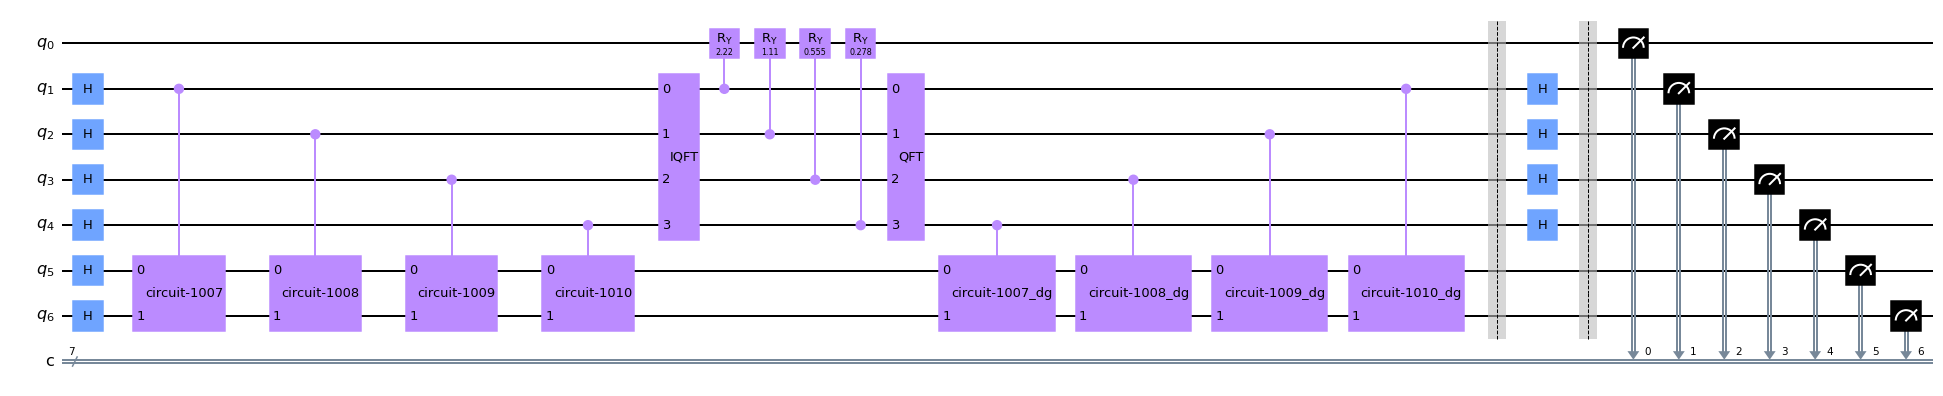

In [22]:
qc = QuantumCircuit(7, 7)
r=3.5

for i in range(1,7):
    qc.h(i)

qc.append(qg1, [1, 5, 6])
qc.append(qg2, [2, 5, 6])
qc.append(qg4, [3, 5, 6])
qc.append(qg8, [4, 5, 6])
qc.append(nIQFT(QuantumRegister(4), 4), [1, 2, 3, 4])
qc.cry(8*(np.pi/2**r), 1, 0)
qc.cry(4*(np.pi/2**r), 2, 0)
qc.cry(2*(np.pi/2**r), 3, 0)
qc.cry(1*(np.pi/2**r), 4, 0)
qc.append(nQFT(QuantumRegister(4), 4), [1, 2, 3, 4])
qc.append(qg1.inverse(), [4, 5, 6])
qc.append(qg2.inverse(), [3, 5, 6])
qc.append(qg4.inverse(), [2, 5, 6])
qc.append(qg8.inverse(), [1, 5, 6])
qc.barrier()
for i in range(1,5):
    qc.h(i)
qc.barrier()

for i in range(7):
    qc.measure(i, i)
    
qc.draw('mpl', fold=-1)

[ 0.        +0.j          0.11402032-0.99347842j  0.        +0.j
  0.        +0.j          0.        +0.j         -0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j         -0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         

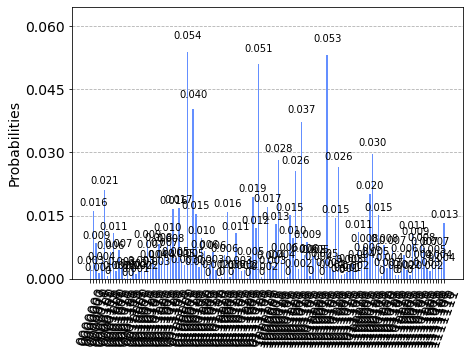

In [23]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots=8192)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
#print(counts)

backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend, shots=8192).result()
statevector = result.get_statevector(qc)

print(statevector)
plot_histogram(counts)

In [14]:
from numpy import binary_repr


binr = []
for j in range(0, 2**7+1):
    binr.append(binary_repr(j, width=7))


kv = dict(zip(binr, statevector))

for l in binr:
    if l[6] == '1':
        print(l, kv[l])
    

0000001 (0.05905703149389162-0.1340722039517274j)
0000011 (0.03648120729577229+0.04150173816838666j)
0000101 (-0.0425676984233872-0.025776914786467053j)
0000111 (0.01588531362977028-0.012837008529090026j)
0001001 (-0.014278211338895124+0.1080398307396005j)
0001011 (0.12447029968134668+0.08934069659240873j)
0001101 (0.07005933680560249-0.02539090101575634j)
0001111 (0.04348779165955329+0.01715942103650944j)
0010001 (0.01287610040434865+0.055869476393224315j)
0010011 (-0.05951515796521602+0.013367384613963036j)
0010101 (-0.07486453579756198+0.0076662861534879684j)
0010111 (0.013037022365311129-0.07286921986219996j)
0011001 (0.04197110465917363-0.0878725447998306j)
0011011 (0.04915299259082082-0.029602797092322875j)
0011101 (0.0959834622932612+0.03308319175770376j)
0011111 (0.06296622989066639+0.038467987492214785j)
0100001 (0.0685701002644886-0.13395550447279456j)
0100011 (-0.045961728651510186+0.05419952984534717j)
0100101 (0.07865968814506356+0.032244422012453644j)
0100111 (0.067052486

<ipython-input-14-bb6981308cca>:6: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  binr.append(binary_repr(j, width=7))


In [43]:
print(statevector)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.        +0.j         -0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.        +0.j          0.        +0.j
 -0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.        +0.j          0.        +0.j
 -0.        +0.j         -0.45504873-0.89046654j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         